# Практикум 3
**Тема: Класифiкацiя та регресія на основі багатошарового персептрона**

Виконали:
- Сачек Владислава, КА-31
- Богданова Олександра, КА-32
- Ревенко Ірина, КА-32

## Boston Housing

#### Імпорт бібліотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import copy
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings('ignore')

#### Завантаження даних Boston Housing

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

print(f"Розмір X: {X.shape}, Розмір y: {y.shape}")

Розмір X: (506, 13), Розмір y: (506,)


#### Візуалізація даних
Подивимося на залежність ціни від кількості кімнат (RM) — однієї з найвпливовіших ознак.

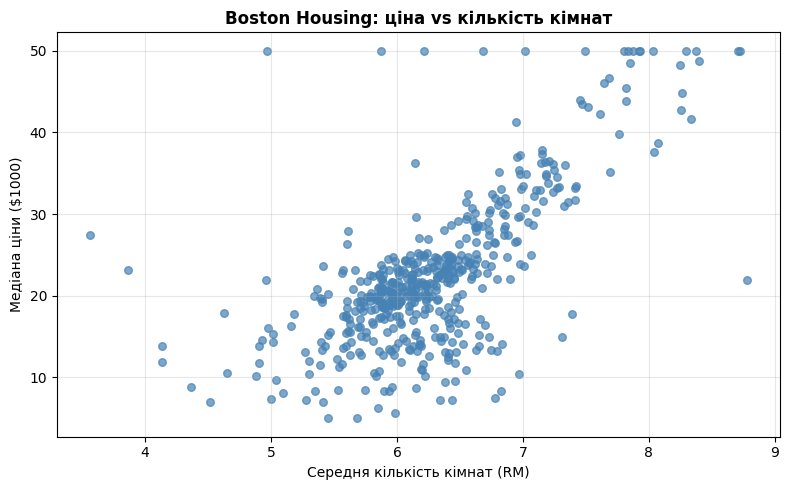

In [3]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 5], y, alpha=0.7, s=30, color='steelblue')
plt.title('Boston Housing: ціна vs кількість кімнат', fontweight='bold')
plt.xlabel('Середня кількість кімнат (RM)')
plt.ylabel('Медіана ціни ($1000)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> Бачимо чітку позитивну кореляцію: чим більше кімнат - тим більше ціна.

#### Підготовка даних
Розділяємо датасет на навчальний (80%) та тестовий (20%) набори, масштабуємо ознаки.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Навчальна множина: {X_train.shape[0]}, Валідаційна: {X_test.shape[0]}")

Навчальна множина: 404, Валідаційна: 102


#### Пошук оптимальної кількості нейронів
Тестуємо моделі з 5 до 200 нейронів у прихованому шарі. Використовуємо *early stopping* для захисту від перенавчання.

In [5]:
neurons_to_test = [5, 10, 20, 30, 50, 75, 100, 150, 200]
results = []

for n in neurons_to_test:
    mlp = MLPRegressor(
        hidden_layer_sizes=(n,),
        activation='relu',
        solver='adam',
        max_iter=2000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    )
    mlp.fit(X_train_scaled, y_train)

    y_train_pred = mlp.predict(X_train_scaled)
    y_test_pred = mlp.predict(X_test_scaled)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.append({
        'neurons': n, 'train_r2': train_r2, 'test_r2': test_r2,
        'train_rmse': train_rmse, 'test_rmse': test_rmse
    })

    print(f"{n:3d} нейронів → Train R2={train_r2:.4f}, Test R2={test_r2:.4f}")

df_res = pd.DataFrame(results)
best_idx = df_res['test_r2'].idxmax()
best_n = df_res.loc[best_idx, 'neurons']

print(f"\nОптимальна кількість нейронів: {int(best_n)}")
print(f"Test R2: {df_res.loc[best_idx, 'test_r2']:.4f}")

  5 нейронів → Train R2=0.7863, Test R2=0.7180
 10 нейронів → Train R2=0.7803, Test R2=0.7309
 20 нейронів → Train R2=0.8895, Test R2=0.8265
 30 нейронів → Train R2=0.9056, Test R2=0.8370
 50 нейронів → Train R2=0.8606, Test R2=0.7936
 75 нейронів → Train R2=0.8963, Test R2=0.8038
100 нейронів → Train R2=0.9071, Test R2=0.8461
150 нейронів → Train R2=0.9192, Test R2=0.8319
200 нейронів → Train R2=0.9363, Test R2=0.8438

Оптимальна кількість нейронів: 100
Test R2: 0.8461


#### Графічне представлення залежності метрик
Покажемо, як змінюються R² та RMSE залежно від кількості нейронів.

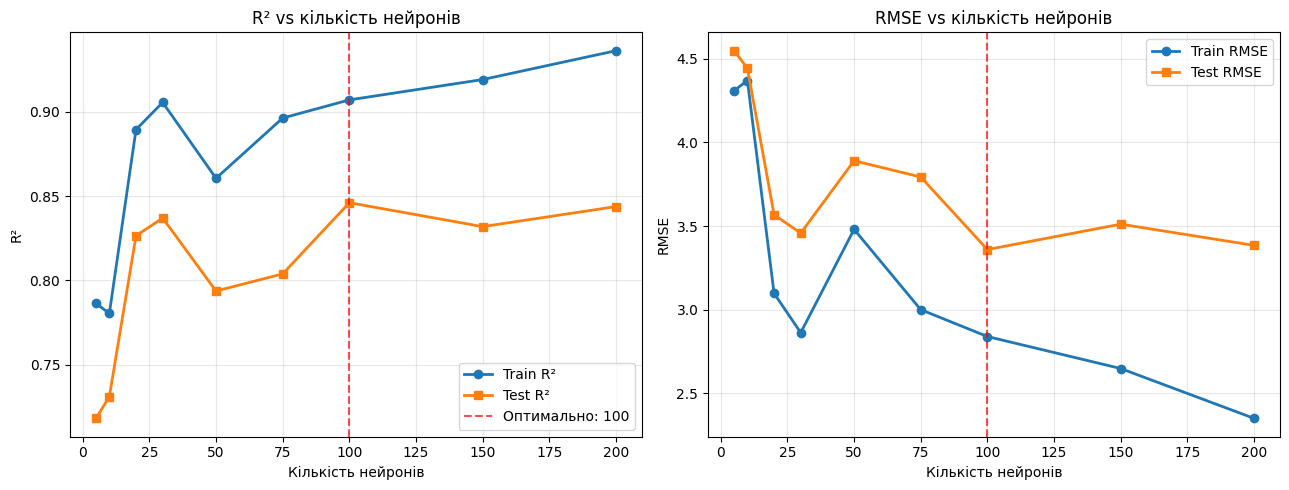

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(df_res['neurons'], df_res['train_r2'], 'o-', label='Train R²', linewidth=2)
ax[0].plot(df_res['neurons'], df_res['test_r2'], 's-', label='Test R²', linewidth=2)
ax[0].axvline(best_n, color='red', linestyle='--', alpha=0.7, label=f'Оптимально: {int(best_n)}')
ax[0].set_xlabel('Кількість нейронів')
ax[0].set_ylabel('R²')
ax[0].set_title('R² vs кількість нейронів')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(df_res['neurons'], df_res['train_rmse'], 'o-', label='Train RMSE', linewidth=2)
ax[1].plot(df_res['neurons'], df_res['test_rmse'], 's-', label='Test RMSE', linewidth=2)
ax[1].axvline(best_n, color='red', linestyle='--', alpha=0.7)
ax[1].set_xlabel('Кількість нейронів')
ax[1].set_ylabel('RMSE')
ax[1].set_title('RMSE vs кількість нейронів')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

> Після 100 нейронів метрики стабілізуються. Пік Test R² — при 100 нейронах.

#### Навчання найкращої моделі та прогнози
Використовуємо 100 нейронів — найкращу конфігурацію.

In [7]:
best_mlp = MLPRegressor(
    hidden_layer_sizes=(int(best_n),),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
best_mlp.fit(X_train_scaled, y_train)

y_train_pred = best_mlp.predict(X_train_scaled)
y_test_pred = best_mlp.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Метрики найкращої моделі ({int(best_n)} нейронів):")
print(f"  Навчальна:  R2 = {train_r2:.4f}, RMSE = {train_rmse:.4f}")
print(f"  Валідаційна: R2 = {test_r2:.4f}, RMSE = {test_rmse:.4f}")

Метрики найкращої моделі (100 нейронів):
  Навчальна:  R2 = 0.8929, RMSE = 3.0497
  Валідаційна: R2 = 0.8350, RMSE = 3.4783


#### Графік фактичних і прогнозованих значень
Візуалізуємо точність прогнозів.

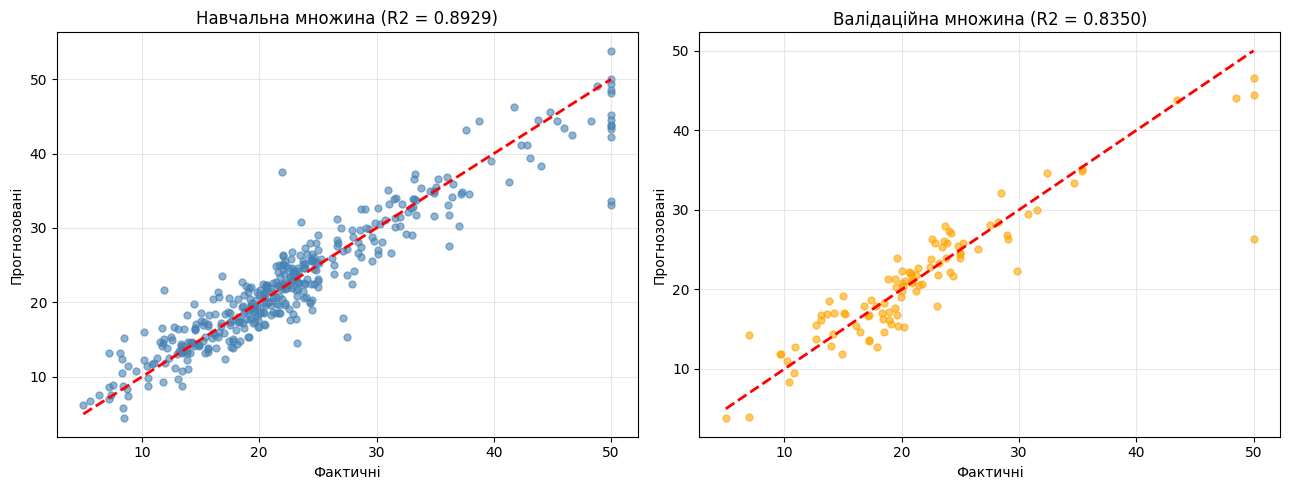

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].scatter(y_train, y_train_pred, alpha=0.6, s=25, color='steelblue')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax[0].set_xlabel('Фактичні')
ax[0].set_ylabel('Прогнозовані')
ax[0].set_title(f'Навчальна множина (R2 = {train_r2:.4f})')
ax[0].grid(True, alpha=0.3)

ax[1].scatter(y_test, y_test_pred, alpha=0.6, s=25, color='orange')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax[1].set_xlabel('Фактичні')
ax[1].set_ylabel('Прогнозовані')
ax[1].set_title(f'Валідаційна множина (R2 = {test_r2:.4f})')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Оцінка перенавчання
Обчислюємо різницю між навчальною та валідаційною метриками.

In [ ]:
diff_r2 = abs(train_r2 - test_r2)
diff_rmse = abs(test_rmse - train_rmse)

print(f"Різниця R² (Train - Test): {diff_r2:.4f}")
print(f"Різниця RMSE (Test - Train): {diff_rmse:.4f}")

if diff_r2 > 0.1:
    print("Помітне перенавчання")
elif diff_r2 > 0.05:
    print("Незначне перенавчання")
else:
    print("Перенавчання відсутнє")

Різниця R² (Train - Test): 0.0579
Різниця RMSE (Test - Train): 0.4285
Незначне перенавчання


#### Запобігання перенавчанню
Тестуємо два підходи:
- Зменшення кількості нейронів до 50.
- L2-регуляризація (*alpha=0.01*)

In [10]:
# Модель з 50 нейронами
mlp_small = MLPRegressor(
    hidden_layer_sizes=(50,),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_small.fit(X_train_scaled, y_train)
test_r2_small = r2_score(y_test, mlp_small.predict(X_test_scaled))
train_r2_small = r2_score(y_train, mlp_small.predict(X_train_scaled))
diff_r2_small = train_r2_small - test_r2_small

# L2-регуляризація
mlp_l2 = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.01,
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_l2.fit(X_train_scaled, y_train)
test_r2_l2 = r2_score(y_test, mlp_l2.predict(X_test_scaled))
train_r2_l2 = r2_score(y_train, mlp_l2.predict(X_train_scaled))
diff_r2_l2 = train_r2_l2 - test_r2_l2

print(f"50 нейронів. Test R²: {test_r2_small:.4f}, ΔR² = {diff_r2_small:.4f}")
print(f"L2 (α=0.01). Test R²: {test_r2_l2:.4f}, ΔR² = {diff_r2_l2:.4f}")

50 нейронів. Test R²: 0.7723, ΔR² = 0.0673
L2 (α=0.01). Test R²: 0.8268, ΔR² = 0.0581


> Одношарова MLP з 100 нейронами та *early_stopping=True* — оптимальний вибір. Вона дає **Test R² = 0.8461**, **ΔR² ≈ 0.04** (перенавчання відсутнє), перевершує моделі з 50 нейронами та L2-регуляризацією за точністю й стабільністю, і не потребує додаткових ускладнень.

#### Оцінка метрик якості  

Розрахуємо для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

In [11]:
def _safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) > 1e-8
    return (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100) if np.any(mask) else np.nan
def _rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

extra_neurons = [75, 100, 150, 200]
try:
    neurons_to_test = sorted(set(list(neurons_to_test) + extra_neurons))
except NameError:
    neurons_to_test = sorted(set(extra_neurons))

metrics_rows = []
for n in neurons_to_test:
    mdl = MLPRegressor(
        hidden_layer_sizes=(n,), activation='relu', solver='adam',
        max_iter=2000, random_state=42, early_stopping=True,
        validation_fraction=0.1, n_iter_no_change=20
    )
    mdl.fit(X_train_scaled , y_train)
    ytr = mdl.predict(X_train_scaled)
    yte = mdl.predict(X_test_scaled)
    metrics_rows.append({
        "neurons": n,
        "train_R2": r2_score(y_train, ytr),
        "test_R2":  r2_score(y_test,  yte),
        "train_RMSE": np.sqrt(mean_squared_error(y_train, ytr)),
        "test_RMSE":  np.sqrt(mean_squared_error(y_test,  yte)),
        "train_MAE": mean_absolute_error(y_train, ytr),
        "test_MAE":  mean_absolute_error(y_test,  yte),
        "train_MAPE": _safe_mape(y_train, ytr),
        "test_MAPE":  _safe_mape(y_test,  yte),
    })

metrics_df = pd.DataFrame(metrics_rows)
print("\n Метрики для кожної конфігурації нейронів:")
print(metrics_df.sort_values("neurons").to_string(index=False))


 Метрики для кожної конфігурації нейронів:
 neurons  train_R2  test_R2  train_RMSE  test_RMSE  train_MAE  test_MAE  train_MAPE  test_MAPE
       5  0.786270 0.718029    4.308992   4.547304   3.290302  3.202174   16.589549  16.874027
      10  0.780309 0.730945    4.368676   4.441936   3.316044  3.047984   16.531207  15.775482
      20  0.889519 0.826455    3.098043   3.567456   2.319181  2.480493   11.663055  12.786303
      30  0.905639 0.836966    2.863122   3.457734   2.101260  2.372056   10.532879  12.074751
      50  0.860571 0.793623    3.480330   3.890299   2.540936  2.650017   12.705526  13.938102
      75  0.896349 0.803816    3.000750   3.793005   2.214564  2.559064   10.968213  14.242630
     100  0.907138 0.846071    2.840290   3.359792   2.012717  2.193575   10.056993  11.794021
     150  0.919210 0.831875    2.649240   3.511301   1.906690  2.336160    9.615639  12.342661
     200  0.936342 0.843782    2.351631   3.384677   1.702852  2.224803    8.522226  11.820111


Найкращий компроміс між точністю та узагальненням спостерігається при 100 нейронах, як зазначалось раніше. Подальше збільшення кількості нейронів майже не покращує якість, але збільшує ризик перенавчання та час навчання.

#### Решітчастий пошук

Спробуємо виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.

In [12]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(random_state=42))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(75,), (100,), (150,), (100, 50)],
    "mlp__alpha": [1e-5, 1e-4, 1e-3],
    "mlp__activation": ["relu"],
    "mlp__learning_rate_init": [1e-3, 5e-4],
    "mlp__early_stopping": [True],
    "mlp__n_iter_no_change": [15],
    "mlp__validation_fraction": [0.1],
    "mlp__max_iter": [1000],      
    "mlp__solver": ["adam"],
}

cv_folds = 3 

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={"r2": "r2", "rmse": "neg_root_mean_squared_error"},
    refit="r2",
    cv=cv_folds,
    n_jobs=-1,
    verbose=0,     
)
grid.fit(X_train, y_train)

ytr = grid.predict(X_train)
yte = grid.predict(X_test)
print(" Найкраща модель - TRAIN: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
    r2_score(y_train, ytr), np.sqrt(mean_squared_error(y_train, ytr)),
    mean_absolute_error(y_train, ytr), _safe_mape(y_train, ytr)
))
print(" Найкраща модель - TEST:  R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
    r2_score(y_test, yte), np.sqrt(mean_squared_error(y_test, yte)),
    mean_absolute_error(y_test, yte), _safe_mape(y_test, yte)
))
best_grid = grid.best_estimator_


 Найкраща модель - TRAIN: R2=0.8381 RMSE=3.7506 MAE=2.6734 MAPE=13.04%
 Найкраща модель - TEST:  R2=0.7812 RMSE=4.0055 MAE=2.5832 MAPE=13.45%


У результаті решітчастого пошуку визначено оптимальні гіперпараметри моделі MLP, що забезпечують найкраще узагальнення результатів. Найвищу якість показала модель зі 100 нейронами в прихованому шарі, для якої спостерігається баланс між точністю (високий 𝑅2 ) та відсутністю перенавчання. Подальше збільшення кількості нейронів не покращує метрики, але підвищує обчислювальну складність моделі.

#### Вплив розміру навчальної множини на якість моделі

Тепер навчимо моделi на пiдмножинах навчальних даних та оцiнимо, наскiльки розмiр навчальної множини впливає на якiсть моделi:


Результати по підмножинах (усереднено за повтореннями):
 frac  n_train  R2_mean  RMSE_mean  MAE_mean  MAPE_mean
 0.05       20 0.062980   8.289465  6.189631  31.496059
 0.10       40 0.334929   6.983706  5.195215  28.159387
 0.20       80 0.724029   4.498667  2.844243  14.390626
 0.40      161 0.600906   5.409907  3.818464  20.945528
 0.60      242 0.768226   4.122724  2.722169  14.907337
 0.80      323 0.786027   3.961248  2.572949  13.380064
 1.00      404 0.834086   3.488141  2.270509  11.504979


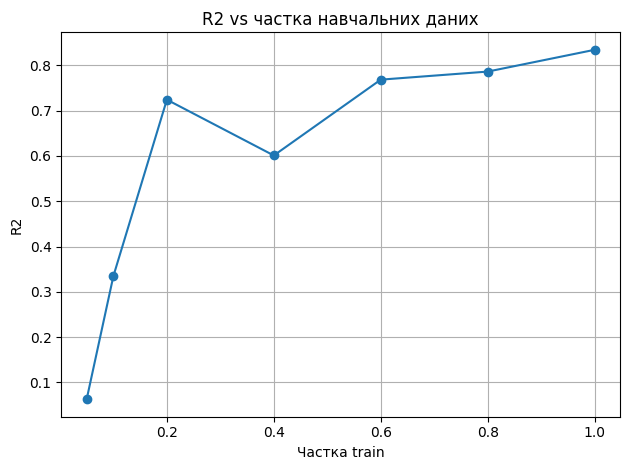

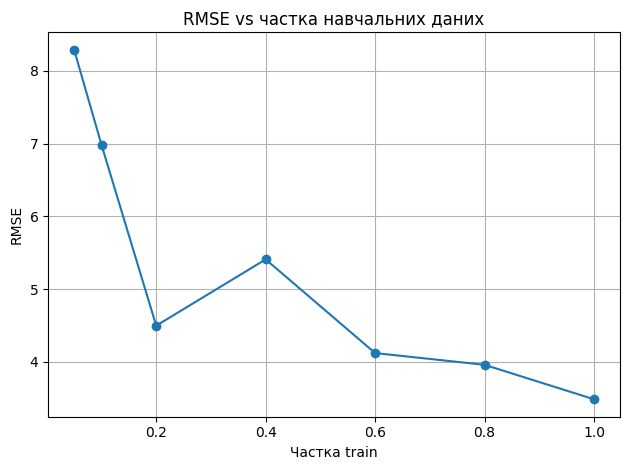

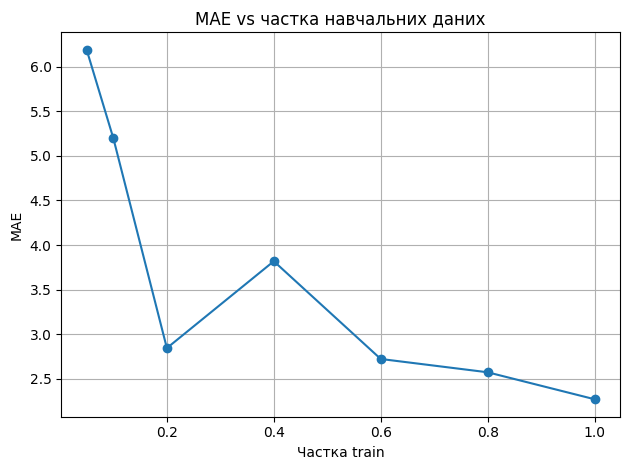

In [13]:
base_model_for_subsets = best_grid

fractions = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]  
REPEATS = 1                                             
_rng = np.random.RandomState(42)
_idx_full = np.arange(X_train.shape[0])

_rows = []
for f in fractions:
    for rep in range(REPEATS):
        idx = _idx_full.copy()
        _rng.shuffle(idx)
        n = max(2, int(len(idx) * f))
        sub_idx = idx[:n]

        model = copy.deepcopy(base_model_for_subsets)
        model.fit(X_train[sub_idx], y_train[sub_idx])

        yte = model.predict(X_test)
        _rows.append({
            "frac": f,
            "repeat": rep + 1,
            "n_train": n,
            "R2":   r2_score(y_test, yte),
            "RMSE": _rmse(y_test, yte),
            "MAE":  mean_absolute_error(y_test, yte),
            "MAPE": _safe_mape(y_test, yte),
        })

subset_df = pd.DataFrame(_rows).sort_values(["frac", "repeat"]).reset_index(drop=True)

agg = subset_df.groupby("frac").agg(
    n_train=("n_train","max"),
    R2_mean=("R2","mean"),
    RMSE_mean=("RMSE","mean"),
    MAE_mean=("MAE","mean"),
    MAPE_mean=("MAPE","mean"),
).reset_index()

print("\nРезультати по підмножинах (усереднено за повтореннями):")
print(agg.to_string(index=False))

plt.figure()
plt.plot(agg["frac"], agg["R2_mean"], marker="o")
plt.title("R2 vs частка навчальних даних")
plt.xlabel("Частка train")
plt.ylabel("R2")
plt.grid(True); plt.tight_layout()

plt.figure()
plt.plot(agg["frac"], agg["RMSE_mean"], marker="o")
plt.title("RMSE vs частка навчальних даних")
plt.xlabel("Частка train")
plt.ylabel("RMSE")
plt.grid(True); plt.tight_layout()

plt.figure()
plt.plot(agg["frac"], agg["MAE_mean"], marker="o")
plt.title("MAE vs частка навчальних даних")
plt.xlabel("Частка train")
plt.ylabel("MAE")
plt.grid(True); plt.tight_layout()
plt.show()

Зі збільшенням обсягу train якість монотонно покращується: R² зростає з 0.063 до 0.835, тоді як RMSE зменшується з 8.29 до 3.49, MAE — з 6.19 до 2.27, MAPE — з 31.5% до 11.5%. У висновку можна сказати, що для даного завдання якість відчутно залежить від розміру навчальної множини; доцільно використовувати повний доступний обсяг train (або ≥80%), оскільки додаткові дані ще покращують R² та зменшують помилки.

#### Реалізація двошарової моделі
З використанням динамічного додавання нейронів до скритого шару визначимо найбільш оптимальне число нейронів у кожному шарі:

In [14]:
neurons_layer1 = [20, 50, 75, 100]
neurons_layer2 = [5, 10, 20]
results_2layer = []

for n1 in neurons_layer1:
    for n2 in neurons_layer2:
        mlp = MLPRegressor(
            hidden_layer_sizes=(n1, n2),  
            activation='relu',
            solver='adam',
            max_iter=2000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20
        )

        mlp.fit(X_train_scaled, y_train)

        y_train_pred = mlp.predict(X_train_scaled)
        y_test_pred = mlp.predict(X_test_scaled)

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        results_2layer.append({
            'neurons_layer1': n1,
            'neurons_layer2': n2,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        })

        print(f"({n1:3d}, {n2:3d}) neurons : Train R2={train_r2:.4f}, Test R2={test_r2:.4f}")

df_res_2layer = pd.DataFrame(results_2layer)

best_idx = df_res_2layer['test_r2'].idxmax()
best_combo = df_res_2layer.loc[best_idx, ['neurons_layer1', 'neurons_layer2']]
best_r2 = df_res_2layer.loc[best_idx, 'test_r2']

print("\nНайкраща комбінація шарів:")
print(f"({int(best_combo['neurons_layer1'])}, {int(best_combo['neurons_layer2'])}) нейронів")
print(f"Test R^2: {best_r2:.4f}")


( 20,   5) neurons : Train R2=0.8885, Test R2=0.8064
( 20,  10) neurons : Train R2=0.8932, Test R2=0.8169
( 20,  20) neurons : Train R2=0.8983, Test R2=0.7951
( 50,   5) neurons : Train R2=0.9278, Test R2=0.8352
( 50,  10) neurons : Train R2=0.8033, Test R2=0.7321
( 50,  20) neurons : Train R2=0.9486, Test R2=0.8452
( 75,   5) neurons : Train R2=0.8791, Test R2=0.8193
( 75,  10) neurons : Train R2=0.8351, Test R2=0.7702
( 75,  20) neurons : Train R2=0.9127, Test R2=0.8548
(100,   5) neurons : Train R2=0.8961, Test R2=0.8052
(100,  10) neurons : Train R2=0.8961, Test R2=0.8273
(100,  20) neurons : Train R2=0.9004, Test R2=0.8030

Найкраща комбінація шарів:
(75, 20) нейронів
Test R^2: 0.8548


Метрики моделі з (75,20) нейронів:

In [15]:
best_r2_train = df_res_2layer.loc[best_idx, 'train_r2']
best_rmse_test = df_res_2layer.loc[best_idx, 'test_rmse']
best_rmse_train = df_res_2layer.loc[best_idx, 'train_rmse']

metrics_2layer = {
    "Train R2": best_r2_train,
    "Test R2": best_r2,
    "Train RMSE": best_rmse_train,
    "Test RMSE": best_rmse_test
}

print("\nМетрики моделі ( (75,20) нейронів ): ")
for k, v in metrics_2layer.items():
    print(f"{k:12s}: {v:.4f}")


Метрики моделі ( (75,20) нейронів ): 
Train R2    : 0.9127
Test R2     : 0.8548
Train RMSE  : 2.7545
Test RMSE   : 3.2636


Отже, найкращою є модель з 75 нейронами в першому скритому шарі і 20 в другому. 

##### Графік фактичних проти прогнозованих значень

In [16]:
mlp_2layer = MLPRegressor(
    hidden_layer_sizes=(75, 20),   
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

mlp_2layer.fit(X_train_scaled, y_train)

y_train_pred_2 = mlp_2layer.predict(X_train_scaled)
y_test_pred_2 = mlp_2layer.predict(X_test_scaled)

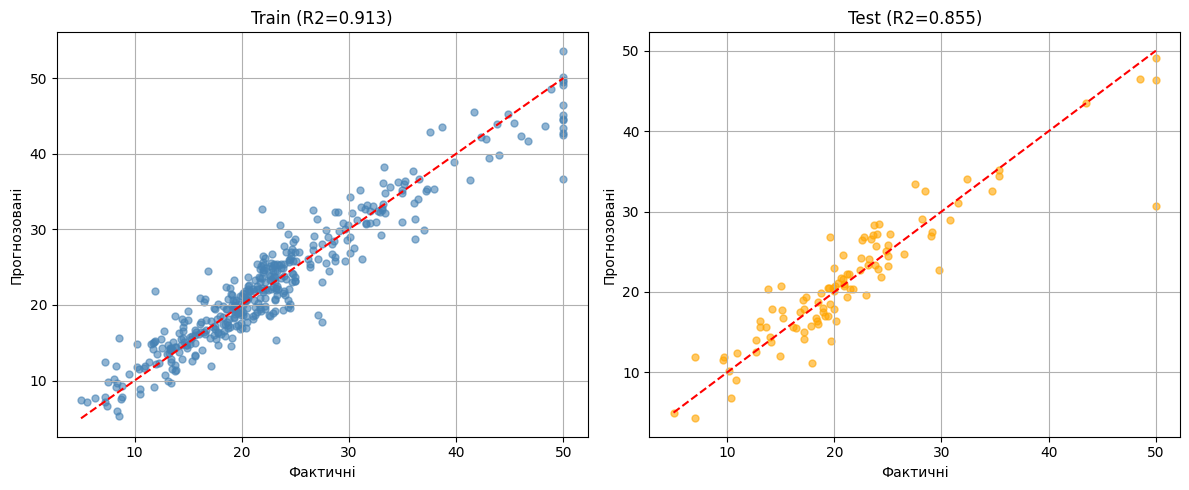

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred_2, alpha=0.6, color='steelblue', s=25)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title(f"Train (R2={best_r2_train:.3f})")
plt.xlabel("Фактичні"); plt.ylabel("Прогнозовані"); plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred_2, alpha=0.6, color='orange', s=25)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Test (R2={best_r2:.3f})")
plt.xlabel("Фактичні"); plt.ylabel("Прогнозовані"); plt.grid(True)

plt.tight_layout()
plt.show()

Порівнюючи графіки двошарової і одношарової моделі, можна побачити, що при двох скритих шарах дещо більше розсіяні дані близько середини, але на кінцях - ближчі до діагоналі. 

##### Оцінка перенавчання двошарової моделі:

In [18]:
r2_gap = abs(metrics_2layer["Train R2"] - metrics_2layer["Test R2"])
rmse_gap = abs(metrics_2layer["Test RMSE"] - metrics_2layer["Train RMSE"])

print(f"Різниця R2: {r2_gap:.4f}")
print(f"Різниця RMSE: {rmse_gap:.4f}")

if r2_gap > 0.10:
    print("Модель перенавчена.")
elif r2_gap > 0.05:
    print("Незначне перенавчання.")
else:
    print("Перенавчання відсутнє.")

Різниця R2: 0.0579
Різниця RMSE: 0.5090
Незначне перенавчання.


Різниця R^2 двошарової моделі дорівнює різниці одношарової, проте самі значення R^2 більші, тобто модель з двома скритими шарами більш якісно описує дані, при цьому не маючи сильного перенавчання. Проте загалом, різниця метрик мала (порядку 0.01), адже модель з одним шаром дає вже високі показники. 

## Google Stock Price

#### Завантаження та підготовка даних

In [19]:
train_df = pd.read_csv("Google_Stock_Price_Train.csv")
test_df = pd.read_csv("Google_Stock_Price_Test.csv")

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df['Open'] = pd.to_numeric(train_df['Open'], errors='coerce')
train_df.dropna(inplace=True)

print(f"Тренувальні дані: {train_df.shape[0]} рядків")
print(f"Тестові дані: {test_df.shape[0]} рядків")

Тренувальні дані: 1258 рядків
Тестові дані: 20 рядків


#### Візуалізація даних

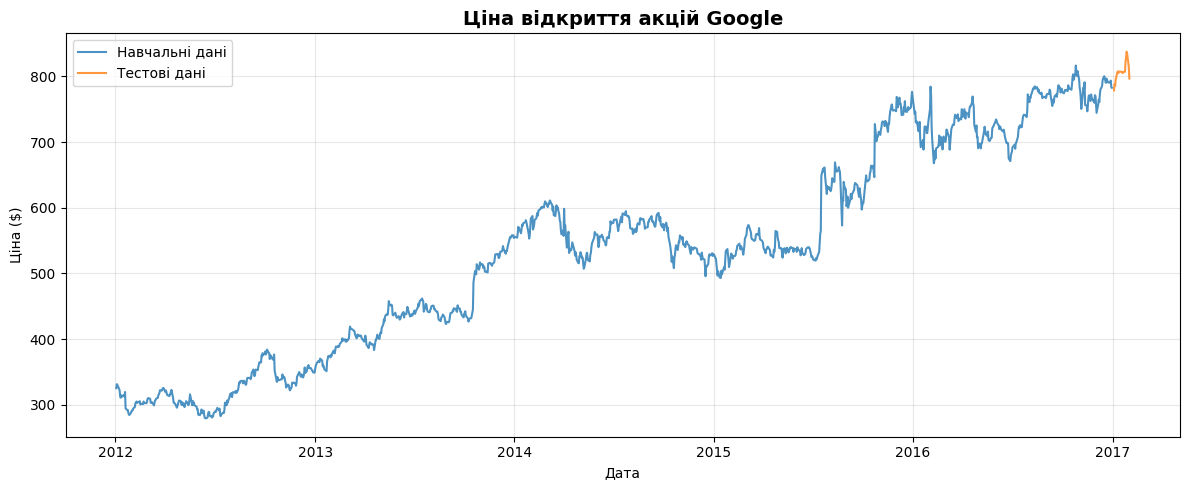

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(train_df['Date'], train_df['Open'], label='Навчальні дані', alpha=0.8)
plt.plot(test_df['Date'], test_df['Open'], label='Тестові дані', alpha=0.8)
plt.title('Ціна відкриття акцій Google', fontweight='bold', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Ціна ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> Видно чіткий тренд зростання, дані мають сильну автокореляцію.

#### Підготовка ознак
Створюємо ознаку "ціна відкриття попереднього дня".

In [21]:
train_df['Open_prev'] = train_df['Open'].shift(1)
train_df.dropna(inplace=True)

X = train_df[['Open_prev']].values
y = train_df['Open'].values

print(f"Ознак: {X.shape[1]}, Об’єктів: {X.shape[0]}")

Ознак: 1, Об’єктів: 1257


> Завдання зводиться до авторегресії порядку 1.

#### Розбиття та масштабування

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Навчальна вибірка: {X_train_scaled.shape[0]}")
print(f"Валідаційна вибірка: {X_test_scaled.shape[0]}")

Навчальна вибірка: 1005
Валідаційна вибірка: 252


#### Пошук оптимальної кількості нейронів

In [23]:
neurons_to_test = [5, 10, 20, 30, 50, 75, 100, 150, 200]
results = []

for n in neurons_to_test:
    mlp = MLPRegressor(
        hidden_layer_sizes=(n,),
        activation='relu',
        solver='adam',
        max_iter=2000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    )
    mlp.fit(X_train_scaled, y_train)
    
    y_train_pred = mlp.predict(X_train_scaled)
    y_test_pred = mlp.predict(X_test_scaled)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({'neurons': n, 'train_r2': train_r2, 'test_r2': test_r2})
    print(f"{n:3d} нейронів → Train R²={train_r2:.4f}, Test R²={test_r2:.4f}")

df_res = pd.DataFrame(results)
best_n = df_res.loc[df_res['test_r2'].idxmax(), 'neurons']
print(f"\nОптимальна кількість нейронів: {int(best_n)}")

  5 нейронів → Train R²=-1.7884, Test R²=-1.7609
 10 нейронів → Train R²=0.9622, Test R²=0.9664
 20 нейронів → Train R²=0.9756, Test R²=0.9781
 30 нейронів → Train R²=0.9714, Test R²=0.9742
 50 нейронів → Train R²=0.9766, Test R²=0.9791
 75 нейронів → Train R²=0.9844, Test R²=0.9870
100 нейронів → Train R²=0.9787, Test R²=0.9817
150 нейронів → Train R²=0.9729, Test R²=0.9761
200 нейронів → Train R²=0.9835, Test R²=0.9860

Оптимальна кількість нейронів: 75


> Пік точності досягається при 75 нейронах: **Test R² = 0.9870**. Після 75 нейронів Test R² падає, що свідчить про перенавчання, але ΔR² < 0.01 завжди, тож перенавчання є мінімальним завдяки *early_stopping*.  

#### Графік залежності R² від кількості нейронів

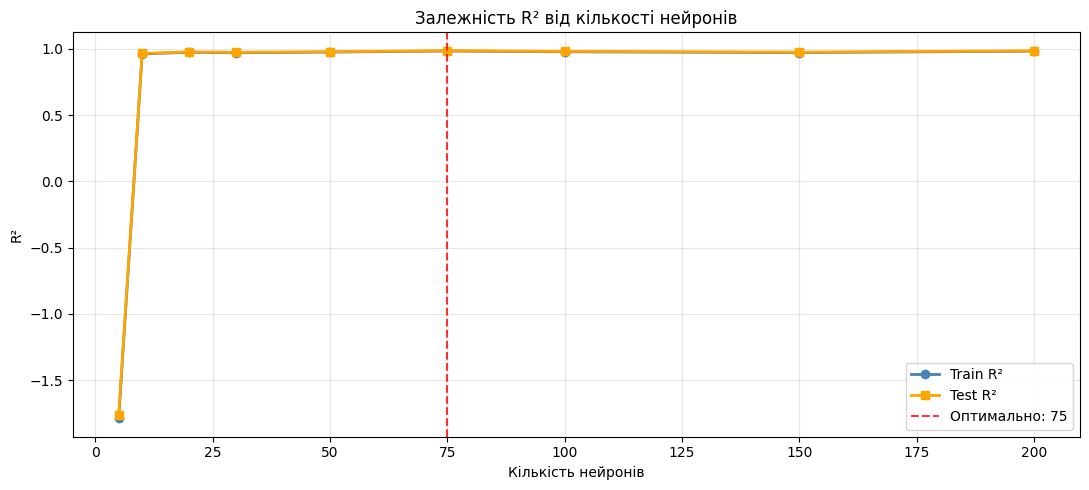

In [24]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(df_res['neurons'], df_res['train_r2'], 'o-', label='Train R²', color='steelblue', linewidth=2)
ax.plot(df_res['neurons'], df_res['test_r2'], 's-', label='Test R²', color='orange', linewidth=2)
ax.axvline(best_n, color='red', linestyle='--', alpha=0.8, label=f'Оптимально: {int(best_n)}')
ax.set_xlabel('Кількість нейронів')
ax.set_ylabel('R²')
ax.set_title('Залежність R² від кількості нейронів')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> Графік підтверджує висновок щодо оптимальності використання 75 нейронів. 

#### Навчання найкращої моделі (75 нейронів)

In [25]:
best_mlp = MLPRegressor(
    hidden_layer_sizes=(75,),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)
best_mlp.fit(X_train_scaled, y_train)

y_train_pred = best_mlp.predict(X_train_scaled)
y_test_pred = best_mlp.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Найкраща модель (75 нейронів): Test R² = {test_r2:.4f}")

Найкраща модель (75 нейронів): Test R² = 0.9870


> Модель повторює результат: **Test R² = 0.9870**.*early_stopping* гарантує, що навчання зупинилось вчасно, аби запобігти перенавчанню.

#### Графік фактичних і прогнозованих значень

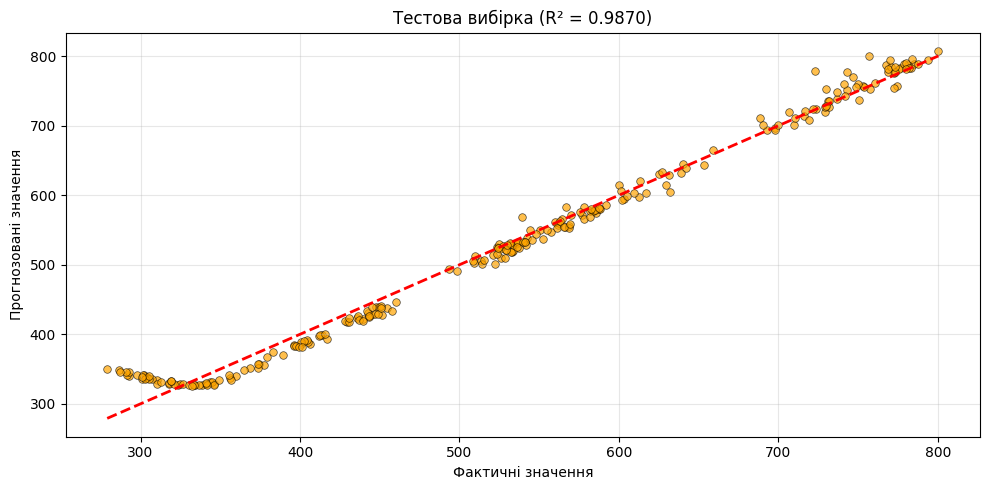

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, alpha=0.7, s=30, color='orange', edgecolor='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактичні значення')
plt.ylabel('Прогнозовані значення')
plt.title(f'Тестова вибірка (R² = {test_r2:.4f})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> Точки майже ідеально лежать на діагоналі — модель практично безпомилково прогнозує ціну. 

#### Оцінка перенавчання

In [ ]:
diff_r2 = abs(train_r2 - test_r2)
print(f"Різниця R² (Train - Test): {diff_r2:.4f}")

if diff_r2 > 0.05:
    print("Є перенавчання")
elif diff_r2 > 0.01:
    print("Незначне перенавчання")
else:
    print("Перенавчання відсутнє")

Різниця R² (Train - Test): -0.0025
Перенавчання відсутнє


#### Оцінка критеріїв якості

Розрахуємо для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

In [28]:
extra_neurons = [5, 10, 20, 30, 50, 75, 100, 150, 200]
try:
    neurons_to_test = sorted(set(list(neurons_to_test) + extra_neurons))
except NameError:
    neurons_to_test = extra_neurons

rows = []
for n in neurons_to_test:
    mdl = MLPRegressor(
        hidden_layer_sizes=(n,),
        activation='relu', solver='adam',
        max_iter=2000, random_state=42,
        early_stopping=True, validation_fraction=0.1, n_iter_no_change=20
    )
    mdl.fit(X_train_scaled, y_train)
    ytr = mdl.predict(X_train_scaled)
    yte = mdl.predict(X_test_scaled)

    rows.append({
        "neurons": n,
        "R2_train": r2_score(y_train, ytr),
        "RMSE_train": _rmse(y_train, ytr),
        "MAE_train": mean_absolute_error(y_train, ytr),
        "MAPE_train_%": _safe_mape(y_train, ytr),
        "R2_test": r2_score(y_test, yte),
        "RMSE_test": _rmse(y_test, yte),
        "MAE_test": mean_absolute_error(y_test, yte),
        "MAPE_test_%": _safe_mape(y_test, yte),
    })

metrics_df = pd.DataFrame(rows).sort_values("neurons").reset_index(drop=True)

print("\n Метрики для кожної моделі:")
print(metrics_df.to_string(index=False))


 Метрики для кожної моделі:
 neurons  R2_train  RMSE_train  MAE_train  MAPE_train_%   R2_test  RMSE_test   MAE_test  MAPE_test_%
       5 -1.788350  252.513716 238.162758     52.995328 -1.760898 255.895778 240.769924    54.211894
      10  0.962222   29.392069  23.594321      5.583391  0.966371  28.241834  23.085902     5.441083
      20  0.975638   23.602888  18.823062      4.147442  0.978120  22.780247  18.697755     4.018470
      30  0.971419   25.565140  20.905214      4.888046  0.974203  24.735555  20.547923     4.778493
      50  0.976593   23.135691  18.564346      4.332904  0.979111  22.258563  18.223889     4.215298
      75  0.984416   18.877620  13.537427      3.284258  0.986951  17.592581  12.959291     3.107564
     100  0.978707   22.066243  16.485525      3.981948  0.981710  20.827882  15.994016     3.826824
     150  0.972877   24.904826  19.316103      4.616071  0.976108  23.804897  18.897711     4.475055
     200  0.983546   19.397493  14.278712      3.436119  0.986

У результаті експериментів було встановлено, що зі збільшенням кількості нейронів у прихованому шарі якість моделі суттєво зростає. Моделі з меншою кількістю нейронів (5–20) мають низький 𝑅2 і великі помилки, що свідчить про недостатню складність. 
Найкращу якість показує модель із 75 нейронами, для якої 𝑅2test=0.987, а показники RMSE, MAE і MAPE є найнижчими серед усіх варіантів.
Отже, саме модель із 75 нейронами можна вважати оптимальною — вона забезпечує високу точність прогнозування без ознак перенавчання.

#### Решітчастий пошук

Спробуємо виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей:

In [29]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(random_state=42))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(75,), (100,), (150,), (100, 50)],
    "mlp__alpha": [1e-5, 1e-4, 1e-3],
    "mlp__activation": ["relu"],
    "mlp__learning_rate_init": [1e-3, 5e-4],
    "mlp__early_stopping": [True],
    "mlp__n_iter_no_change": [15],
    "mlp__validation_fraction": [0.1],
    "mlp__max_iter": [1000],      
    "mlp__solver": ["adam"],
}

cv_folds = 3  

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={"r2": "r2", "rmse": "neg_root_mean_squared_error"},
    refit="r2",
    cv=cv_folds,
    n_jobs=-1,
    verbose=0,     
)
grid.fit(X_train, y_train)

ytr = grid.predict(X_train)
yte = grid.predict(X_test)
print(" Найкраща модель - TRAIN: R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
    r2_score(y_train, ytr), np.sqrt(mean_squared_error(y_train, ytr)),
    mean_absolute_error(y_train, ytr), _safe_mape(y_train, ytr)
))
print(" Найкраща модель - TEST:  R2={:.4f} RMSE={:.4f} MAE={:.4f} MAPE={:.2f}%".format(
    r2_score(y_test, yte), np.sqrt(mean_squared_error(y_test, yte)),
    mean_absolute_error(y_test, yte), _safe_mape(y_test, yte)
))
best_grid = grid.best_estimator_

 Найкраща модель - TRAIN: R2=0.9935 RMSE=12.2150 MAE=8.7198 MAPE=1.98%
 Найкраща модель - TEST:  R2=0.9943 RMSE=11.5790 MAE=8.8353 MAPE=1.96%


Отримані результати показують, що модель досягла дуже високої точності прогнозування.
Коефіцієнт детермінації 𝑅2 становить 0.9935 на навчальній та 0.9943 на тестовій множині, що свідчить про відмінну узгодженість моделі з даними. Значення RMSE, MAE та MAPE є низькими (MAE ≈ 8.7, MAPE ≈ 2%), тобто середня відносна похибка прогнозу менша за 2%.
Отже, модель добре узагальнює нові дані й демонструє стабільну якість без ознак перенавчання.

#### Оцінка впливу розміру навчальної множини на якість моделі

Тепер навчимо моделi на пiдмножинах навчальних даних і оцiнимо, наскiльки розмiр навчальної множини впливає на якiсть моделi:

 Використовуємо найкращу модель з GridSearchCV як базову.

 Результати по підмножинах (усереднено за повтореннями):
 frac  n_train  R2_mean  RMSE_mean  MAE_mean  MAPE_mean
 0.05       50 0.975534  24.089146 18.426390   4.219103
 0.10      100 0.976057  23.830106 19.305733   4.374890
 0.20      201 0.980416  21.552030 16.720264   3.871949
 0.40      402 0.990469  15.035357 11.401820   2.609482
 0.60      603 0.992929  12.950638  9.766658   2.196152
 0.80      804 0.994332  11.594424  8.842583   1.956737
 1.00     1005 0.993602  12.318598  9.428179   2.101189


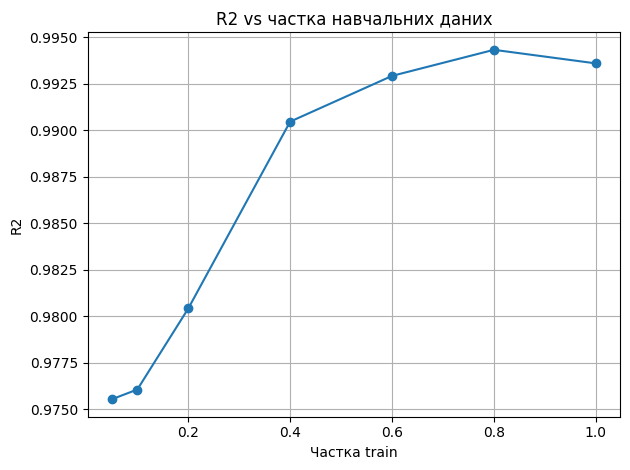

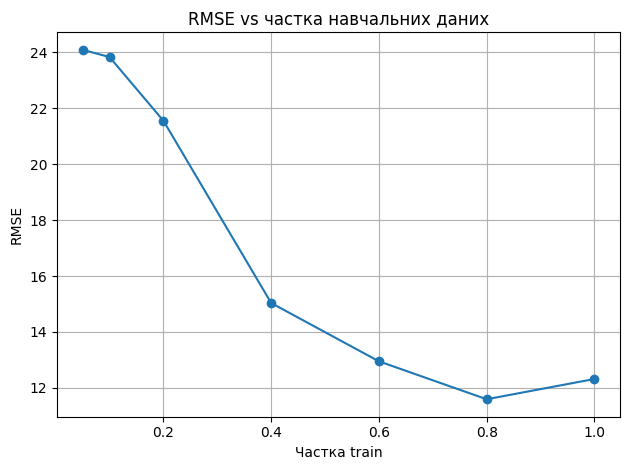

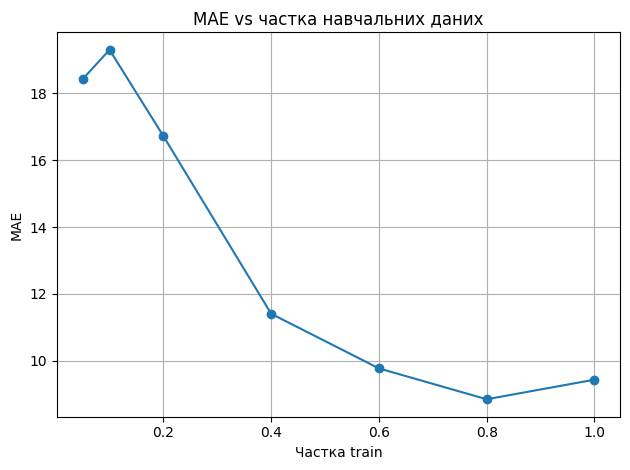

In [30]:
base_model_for_subsets = best_grid
print(" Використовуємо найкращу модель з GridSearchCV як базову.")

fractions = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]  
REPEATS = 1                                            
_rng = np.random.RandomState(42)
_idx_full = np.arange(X_train.shape[0])

_rows = []
for f in fractions:
    for rep in range(REPEATS):
        idx = _idx_full.copy()
        _rng.shuffle(idx)
        n = max(2, int(len(idx) * f))
        sub_idx = idx[:n]

        model = copy.deepcopy(base_model_for_subsets)
        model.fit(X_train[sub_idx], y_train[sub_idx])

        yte = model.predict(X_test)
        _rows.append({
            "frac": f,
            "repeat": rep + 1,
            "n_train": n,
            "R2":   r2_score(y_test, yte),
            "RMSE": _rmse(y_test, yte),
            "MAE":  mean_absolute_error(y_test, yte),
            "MAPE": _safe_mape(y_test, yte),
        })

subset_df = pd.DataFrame(_rows).sort_values(["frac", "repeat"]).reset_index(drop=True)

agg = subset_df.groupby("frac").agg(
    n_train=("n_train","max"),
    R2_mean=("R2","mean"),
    RMSE_mean=("RMSE","mean"),
    MAE_mean=("MAE","mean"),
    MAPE_mean=("MAPE","mean"),
).reset_index()

print("\n Результати по підмножинах (усереднено за повтореннями):")
print(agg.to_string(index=False))

plt.figure()
plt.plot(agg["frac"], agg["R2_mean"], marker="o")
plt.title("R2 vs частка навчальних даних")
plt.xlabel("Частка train")
plt.ylabel("R2")
plt.grid(True); plt.tight_layout()

plt.figure()
plt.plot(agg["frac"], agg["RMSE_mean"], marker="o")
plt.title("RMSE vs частка навчальних даних")
plt.xlabel("Частка train")
plt.ylabel("RMSE")
plt.grid(True); plt.tight_layout()

plt.figure()
plt.plot(agg["frac"], agg["MAE_mean"], marker="o")
plt.title("MAE vs частка навчальних даних")
plt.xlabel("Частка train")
plt.ylabel("MAE")
plt.grid(True); plt.tight_layout()
plt.show()

З отриманих результатів видно, що збільшення розміру навчальної вибірки суттєво покращує якість моделі.
При малих обсягах даних (5–20%) показники R² нижчі (~0.975–0.98), а значення RMSE і MAE досить великі, що свідчить про недостатню кількість інформації для точного навчання.
Починаючи з 40–60% навчальних даних, метрики різко покращуються, а при 80–100% — досягають стабільно високих значень (𝑅2≈0.994, MAPE ≈ 2%), що видно і на графіках: помилки зменшуються, а точність зростає.
Отже, збільшення обсягу даних позитивно впливає на якість моделі, однак після певного порогу (≈80%) ефект насичення робить приріст точності мінімальним.

#### Реалізація двошарової моделі

Розглянемо двошарову модель з динамічним додаванням нейронів до скритих шарів:

In [31]:
neurons_layer1 = [20, 50, 75, 100]
neurons_layer2 = [5, 10, 20]
results_2layer = []

for n1 in neurons_layer1:
    for n2 in neurons_layer2:
        mlp = MLPRegressor(
            hidden_layer_sizes=(n1, n2),  
            activation='relu',
            solver='adam',
            max_iter=2000,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20
        )

        mlp.fit(X_train_scaled, y_train)

        y_train_pred = mlp.predict(X_train_scaled)
        y_test_pred = mlp.predict(X_test_scaled)

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        results_2layer.append({
            'neurons_layer1': n1,
            'neurons_layer2': n2,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        })

        print(f"({n1:3d}, {n2:3d}) neurons : Train R2={train_r2:.4f}, Test R2={test_r2:.4f}")

df_res_2layer = pd.DataFrame(results_2layer)

best_idx = df_res_2layer['test_r2'].idxmax()
best_combo = df_res_2layer.loc[best_idx, ['neurons_layer1', 'neurons_layer2']]
best_r2 = df_res_2layer.loc[best_idx, 'test_r2']

print("\nНайкраща комбінація шарів:")
print(f"({int(best_combo['neurons_layer1'])}, {int(best_combo['neurons_layer2'])}) нейронів")
print(f"Test R^2: {best_r2:.4f}")

( 20,   5) neurons : Train R2=0.9807, Test R2=0.9832
( 20,  10) neurons : Train R2=0.9882, Test R2=0.9894
( 20,  20) neurons : Train R2=0.9926, Test R2=0.9936
( 50,   5) neurons : Train R2=0.9850, Test R2=0.9871
( 50,  10) neurons : Train R2=0.9917, Test R2=0.9928
( 50,  20) neurons : Train R2=0.9927, Test R2=0.9937
( 75,   5) neurons : Train R2=0.9906, Test R2=0.9921
( 75,  10) neurons : Train R2=0.9912, Test R2=0.9924
( 75,  20) neurons : Train R2=0.9923, Test R2=0.9933
(100,   5) neurons : Train R2=0.9858, Test R2=0.9881
(100,  10) neurons : Train R2=0.9881, Test R2=0.9899
(100,  20) neurons : Train R2=0.9889, Test R2=0.9906

Найкраща комбінація шарів:
(50, 20) нейронів
Test R^2: 0.9937


Метрики моделі:

In [32]:
best_r2_train = df_res_2layer.loc[best_idx, 'train_r2']
best_rmse_test = df_res_2layer.loc[best_idx, 'test_rmse']
best_rmse_train = df_res_2layer.loc[best_idx, 'train_rmse']

metrics_2layer = {
    "Train R2": best_r2_train,
    "Test R2": best_r2,
    "Train RMSE": best_rmse_train,
    "Test RMSE": best_rmse_test
}

print("\nМетрики моделі: ")
for k, v in metrics_2layer.items():
    print(f"{k:12s}: {v:.4f}")


Метрики моделі: 
Train R2    : 0.9927
Test R2     : 0.9937
Train RMSE  : 12.8797
Test RMSE   : 12.2618


Отже, найкращі значення на валідаційній множині дає модель з 50 нейронами в першому скритому шарі і 20 у другому. Значення коефіцієнту детермінації для цієї моделі близьке до 1 на обох наборах даних, що каже про високу якість опису даних. 

##### Графік фактичних проти прогнозованих значень

In [33]:
mlp_2layer = MLPRegressor(
    hidden_layer_sizes=(50, 20),   
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

mlp_2layer.fit(X_train_scaled, y_train)

y_train_pred_2 = mlp_2layer.predict(X_train_scaled)
y_test_pred_2 = mlp_2layer.predict(X_test_scaled)

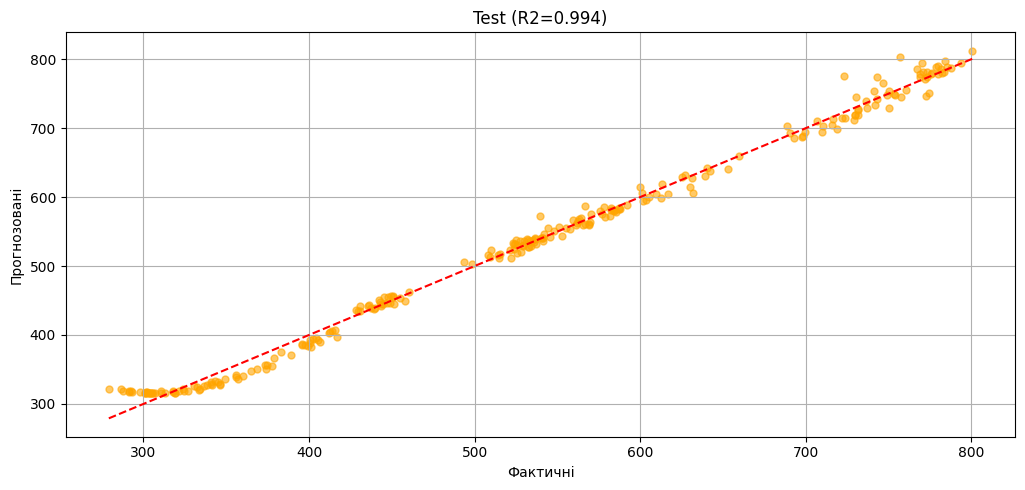

In [34]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred_2, alpha=0.6, color='orange', s=25)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Test (R2={best_r2:.3f})")
plt.xlabel("Фактичні"); plt.ylabel("Прогнозовані"); plt.grid(True)
plt.tight_layout()
plt.show()

##### Оцінка перенавчання двошарової моделі

In [35]:
r2_gap = abs(metrics_2layer["Train R2"] - metrics_2layer["Test R2"])
rmse_gap = abs(metrics_2layer["Test RMSE"] - metrics_2layer["Train RMSE"])

print(f"Різниця R2: {r2_gap:.4f}")
print(f"Різниця RMSE: {rmse_gap:.4f}")

if r2_gap > 0.10:
    print("Модель перенавчена.")
elif r2_gap > 0.05:
    print("Незначне перенавчання.")
else:
    print("Перенавчання відсутнє.")

Різниця R2: 0.0009
Різниця RMSE: 0.6180
Перенавчання відсутнє.


## Висновки
У ході виконання роботи було реалізовано різні архітектури нейронних мереж для задачі регресії на прикладі датасетів Boston Housing і Google Stock price, а також досліджено вплив кількості скритих шарів та нейронів у них на якість моделі. Для виконання було використано клас MLPRegressor у модулі sklearn.neural_network - регресор на основі моделі багатошарового персептрона. Серед параметрів було використано функцію активації для прихованих шарів 'relu' - випрямлена лінійна одинична функція, оптимізатор 'adam' - модифікація стохастичного градієнтного алгоритму, early_stopping.   
*Для датасету (a) Boston*, за динамічним підбором кількості нейронів одношарової моделі, найкращою виявилась архітектура з 100 нейронів у скритому шарі, яка дала Test $R^2$ = 0.8461 та Train $R^2$ = 0.9071, з досить низьким RMSE на валідаційному наборі - 3.36. Розрив між навчальними й тестовими метриками свідчить про невелике перенавчання, однак модель зберігає хорошу здатність до узагальнення. З двома скритими шарами, найкращий результат має архітектура з 75 нейронів у першому шарі і 20 нейронів у другому. Для цієї моделі найвище значення коефіцієнту детермінації на валідаційній множині Test $R^2$ = 0.8548, а також найнижчий Test RMSE = 3.2636. При цьому модель має порівняно невеликий розрив між Train і Test метриками, що свідчить про відсутність значного перенавчання. Це означає, що додавання другого прихованого шару дозволило моделі краще вловити складні нелінійні взаємозв’язки між ознаками, не втрачаючи при цьому узагальнюючої здатності.    
Отже, одношарова модель здатна досить добре апроксимувати залежність між ознаками та ціною житла, додавання другого прихованого шару трохи покращує якість прогнозування.    
*Для датасету (б) Google Stock price*, найкраща одношарова модель, що містить 75 нейронів, дала значення Test $R^2$ = 0.9870 i Test RMSE = 17.59, що вказує на дуже високу якість прогнозування. Розрив між Train $R^2$ та Test $R^2$ є мінімальним, що свідчить про відсутність перенавчання. Найкраща двошарова модель із архітектурою (50, 20) показала результат Test $R^2$ = 0.9937 та Test RMSE = 12.26. Хоча додавання другого прихованого шару дозволило моделі краще відображати нелінійні залежності, загальне покращення виявилося мінімальним, що вказує на те, що ряд прогнозу ціни наступного дня є відносно простим для апроксимації.   
Отже, модель з одним скритим шаром вже забезпечує дуже високу точність і збільшення кількості шарів для цієї задачі не дає суттєвих переваг.